<title>Toxic Player Detection Dota 2</title>

In [41]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
import gensim
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, Bidirectional, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
import pickle

nltk.download('punkt')

SEQUENCE_LENGTH = 100
EMBEDDING_SIZE = 128
BATCH_SIZE = 32
EPOCH = 10
PAD_WORD = "__PAD__"
WORD_EMBEDDING_FILE = 'word_embedding.csv'
TOKENIZER_FILE = 'tokenizer.pickle'
BEST_CLASSIFICATION_MODEL_JSON = 'best_classification_model.json'
BEST_CLASSIFICATION_MODEL_WEIGHT = 'best_classification_model.h5'


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def is_match(X1, X2):
    for i in range(len(X1)):
        arr1 = X1[i]
        arr2 = X2[i]
        if(len(arr1) != len(arr2)):
            print(i)
            return False
    return True

def entity_masking(sentence):
    return sentence

def load_word_embedding_and_tokenizer(embedding_size, entity_masking):
    masking_text = ''
    if(entity_masking):
        masking_text = '_with_masking'
        
    word_embedding_file = 'word_embedding_' + str(embedding_size) + masking_text +'.csv'
    tokenizer_file = 'tokenizer_' + str(embedding_size) + masking_text + '.pickle'
    
    #load word embedding
    word_embedding = np.loadtxt(word_embedding_file, delimiter=',')
    #load tokenizer 
    with open(tokenizer_file, 'rb') as handle:
        tokenizer = pickle.load(handle)
        
    return word_embedding, tokenizer

def save_best_model(best_model):
    best_model_json = best_model.to_json()
    with open(BEST_CLASSIFICATION_MODEL_JSON, "w") as json_file:
        json_file.write(best_model_json)
    # serialize weights to HDF5
    best_model.save_weights(BEST_CLASSIFICATION_MODEL_WEIGHT)
    print("Saved model to disk")
    
def load_best_model():
    json_file = open(BEST_CLASSIFICATION_MODEL_JSON, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(BEST_CLASSIFICATION_MODEL_WEIGHT)
    print("Loaded model from disk")
    return loaded_model

def preprocess(X_raw, embedding_size, entity_masking):
    word_embedding, tokenizer = load_word_embedding_and_tokenizer(embedding_size, entity_masking)
    
    if(entity_masking):
        print('sent_tokenize')
        X_raw = [ sent_tokenize(sentence) for sentence in X_raw ]
    
    X = tokenizer.texts_to_sequences(X_raw)
    X = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', value=0)
    return X

def do_experiment(X_raw, y_raw, technique, embedding_size, entity_masking=False, dropout_layer=False):
    
    word_embedding, tokenizer = load_word_embedding_and_tokenizer(embedding_size, entity_masking)

    if(entity_masking):
        print('sent_tokenize')
        X_raw = [ sent_tokenize(sentence) for sentence in X_raw ]
    
    #text to sequence
    X = tokenizer.texts_to_sequences(X_raw)
    y = to_categorical(y_raw)
    
    #padding
    X = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', value=0)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)
    cvscores = []
    for train, test in kfold.split(X_raw, y_raw):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        
        #create model
        model_val = Sequential()
        model_val.add(Embedding(
            input_dim=len(tokenizer.word_index)+1, 
            output_dim=embedding_size, 
            input_length=SEQUENCE_LENGTH, 
            weights=[word_embedding],
            trainable=False))
        
        if(technique == 'lstm'):
            model_val.add(LSTM(128, recurrent_dropout=0.2))
        else:
            model_val.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))

        if(dropout_layer):
            model_val.add(Dropout(0.3))    
        model_val.add(Dense(2, activation="softmax"))
        # compile as rmsprop optimizer
        # aswell as with recall metric
        model_val.compile(optimizer="rmsprop", loss="categorical_crossentropy", 
              metrics=["accuracy", f1_m])
        
        model_val.summary()
        # Fit the model
        model_val.fit(X_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
        # evaluate the model
        scores = model_val.evaluate(X_test, y_test)
        print("%s: %.2f%%" % (model_val.metrics_names[2], scores[2]*100))
        cvscores.append(scores[2] * 100)
        
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    
def train_best_model(X_raw, y_raw, technique, embedding_size, entity_masking=False, dropout_layer=False):
    
    word_embedding, tokenizer = load_word_embedding_and_tokenizer(embedding_size, entity_masking)

    if(entity_masking):
        print('sent_tokenize')
        X_raw = [ sent_tokenize(sentence) for sentence in X_raw ]
    
    print(type(tokenizer))
    #text to sequence
    X = tokenizer.texts_to_sequences(X_raw)
    y = to_categorical(y_raw)
    
    #padding
    X = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', value=0)
        
    #create model
    model_val = Sequential()
    model_val.add(Embedding(
        input_dim=len(tokenizer.word_index)+1, 
        output_dim=embedding_size, 
        input_length=SEQUENCE_LENGTH, 
        weights=[word_embedding],
        trainable=False))

    if(technique == 'lstm'):
        model_val.add(LSTM(128, recurrent_dropout=0.2))
    else:
        model_val.add(Bidirectional(LSTM(128, recurrent_dropout=0.2)))

    if(dropout_layer):
        model_val.add(Dropout(0.3))    
    model_val.add(Dense(2, activation="softmax"))
    # compile as rmsprop optimizer
    # aswell as with recall metric
    model_val.compile(optimizer="rmsprop", loss="categorical_crossentropy", 
          metrics=["accuracy", f1_m])

    model_val.summary()
    # Fit the model
    model_val.fit(X, y, epochs=EPOCH, batch_size=BATCH_SIZE)
    
    return model_val
       

        

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\isjha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<h1>Preprocess Raw Data</h1>

In [3]:
data = pd.read_csv("dota2_chat_messages.csv", encoding="utf_8", usecols=["match", "slot", "text"])
data = data.astype({"match": int, "slot": int, "text": str})
data.head(10)

,match,slot,text
0,0,9,ладно гг
1,0,9,изи
2,0,9,од
3,0,9,ебаный
4,0,9,мусор на войде
5,0,9,мусор
6,0,9,на войде
7,0,9,репорт
8,0,9,100%
9,1,0,twitch.tv/rage_channel


In [14]:
data = data.groupby(['match', 'slot'])['text'].apply('. '.join)
data.reset_index()
data.head(10)

match  slot
0      9       ладно гг . изи. од. ебаный. мусор на войде. му...
1      0       twitch.tv/rage_channel. https://www.twitch.tv/...
       4       где даша?. даша домой. долбоеб сука на дизрапторе
       6       даун с 1 тычки забашил . шок . стример харду с...
       7                                   2 даша подряд . баша 
       8                                                     )))
2      0       yes dog. yeah . fast and furious. too fas. hah...
       2                               no idiot. we too pro. lol
       4                                HAHAH. COMMEND ME TY. EZ
       6                                              carry. lul
Name: text, dtype: object

In [15]:
data = data.reset_index()
data.head(10)

,match,slot,text
0,0,9,ладно гг . изи. од. ебаный. мусор на войде. му...
1,1,0,twitch.tv/rage_channel. https://www.twitch.tv/...
2,1,4,где даша?. даша домой. долбоеб сука на дизрапторе
3,1,6,даун с 1 тычки забашил . шок . стример харду с...
4,1,7,2 даша подряд . баша
5,1,8,)))
6,2,0,yes dog. yeah . fast and furious. too fas. hah...
7,2,2,no idiot. we too pro. lol
8,2,4,HAHAH. COMMEND ME TY. EZ
9,2,6,carry. lul


In [17]:
data.to_csv("dota2_chat_joined.csv")

In [18]:
data.describe()

,match,slot
count,4.747547e+06,4.747547e+06
mean,4.999057e+05,4.493503e+00
std,2.887862e+05,2.873926e+00
min,0.000000e+00,0.000000e+00
25%,2.497860e+05,2.000000e+00
50%,4.999710e+05,5.000000e+00
75%,7.500870e+05,7.000000e+00
max,9.999990e+05,9.000000e+00


<h1>Classification</h1>

In [4]:
#load word embedding
word_embedding = np.loadtxt(WORD_EMBEDDING_FILE, delimiter=',')
#load tokenizer 
with open(TOKENIZER_FILE, 'rb') as handle:
    tokenizer = pickle.load(handle)

In [5]:
data = pd.read_csv("dota2_chat_final.csv", encoding="latin_1", usecols=["category", "match", "slot", "text"])
data["category"].value_counts()

0    320
1    180
Name: category, dtype: int64

In [6]:
data.head()

,category,match,slot,text
0,0,2,0,yes dog. yeah . fast and furious. too fas. hah...
1,0,2,2,no idiot. we too pro. lol
2,0,2,4,HAHAH. COMMEND ME TY. EZ
3,1,6,0,so ya mama likes dick ehh?. figures. ur not ev...
4,1,6,1,reprot. SAD. fucking reported axe. WORST HOOK ...


In [7]:
X_raw = data.drop(columns=['category', 'match', 'slot']).to_numpy().flatten()
y_raw = data.drop(columns=['text', 'match', 'slot']).to_numpy().flatten()

In [8]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

In [9]:
X = tokenizer.texts_to_sequences(X_train_raw)
y = to_categorical(y_train_raw)

In [24]:
X_train_raw[0:15]

array(['gg', 'go next. nice',
       'gg. wow gyro got aghas. end. wombo combo. ez top',
       'WELL PLAYED SHIT CUNTS',
       'noob. fuck pussys . go. BG fucking idiots go play normal all pick. 36 min. haha noob',
       'i will show this game to all my support. how to win. oracle win this shit solo',
       'so ya mama likes dick ehh?. figures. ur not even a good hooker kid. passive shadow blade?. gg',
       'lol. why even try?. Weaver',
       'EZ. medusa. hahaha. lol. YEAH. good to throw . AHAHA. when you got noob carry :D . AHHAA. paasive . only 2nd ans ulti. WT. WTF. paassive medusa. noob . sk . fucking noob medusa. SAD',
       'wtf. ok', '++. nice bkb. Ez wk ez mid ez mirana. boring ass game',
       'nice comming ta. Cm me. Ez. delet dota. Ez',
       'fuck your moms. lich offlane. says. it. all. hahahahahahahaha',
       'bro. U CAN. SEE AXE?. CALL?. gg',
       'gg. we havent support. this invo so fucking asshole. AFK . I AM AFK. SO END FAST. NO HOPE. Cry ??? i said we ne

In [27]:
y[0:15]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [11]:
tokenizer.sequences_to_texts([[231, 66, 174, 114, 13, 771, 175, 772, 19, 92]])

['use commend had ursa me till back enemy end got']

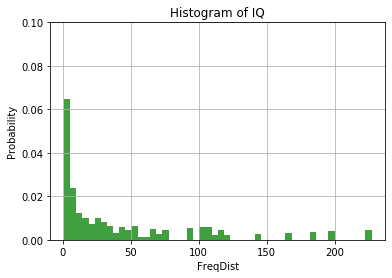

In [35]:
words = []
[words.extend(sentence) for sentence in X]
freqdist = nltk.FreqDist(words)
x_plot = [freqdist[word] for word in words]

# the histogram of the data
n, bins, patches = plt.hist(x_plot, 50, density=1, facecolor='g', alpha=0.75)


plt.xlabel('FreqDist')
plt.ylabel('Probability')
plt.title('Histogram of IQ')
plt.axis([min(x_plot)-10, max(x_plot)+ 10, 0, 0.1])
plt.grid(True)
plt.show()

In [12]:
X_padded = pad_sequences(X, maxlen=SEQUENCE_LENGTH, padding='post', value=0)

In [13]:
X_padded[0]

array([3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

<h1>Validation Test</h1>

In [226]:
# Skenario A
do_experiment(X_train_raw, y_train_raw, 'lstm', 50)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_62 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
lstm_60 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_60 (Dense)             (None, 2)                 258       
Total params: 216,556
Trainable params: 91,906
Non-trainable params: 124,650
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 4s 13ms/sample - loss: 0.6692 - accuracy: 0.6810 - f1_m: 0.6311
Epoch 2/10
279/279 [==============================] - 2s 9ms/sample - loss: 0.5778 - accuracy: 0.6918 - f1_m: 0.6892
Epoch 3/10
279/279 [==============================] - 2s 8ms/sample - l

f1_m: 73.81%
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_64 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
lstm_62 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 258       
Total params: 216,556
Trainable params: 91,906
Non-trainable params: 124,650
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 4s 14ms/sample - loss: 0.6571 - accuracy: 0.6857 - f1_m: 0.6379
Epoch 2/10
280/280 [==============================] - 3s 9ms/sample - loss: 0.5572 - accuracy: 0.6964 - f1_m: 0.6968
Epoch 3/10
280/280 [==============================] - 2s 9ms/sample - loss: 0.5596 - accuracy: 0.7036 -

f1_m: 75.62%
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_66 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
lstm_64 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dense_64 (Dense)             (None, 2)                 258       
Total params: 216,556
Trainable params: 91,906
Non-trainable params: 124,650
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 4s 14ms/sample - loss: 0.7084 - accuracy: 0.6584 - f1_m: 0.6031
Epoch 2/10
281/281 [==============================] - 2s 9ms/sample - loss: 0.6331 - accuracy: 0.6797 - f1_m: 0.6797
Epoch 3/10
281/281 [==============================] - 2s 9ms/sample - loss: 0.5693 - accuracy: 0.7046 -

In [227]:
# Skenario B
do_experiment(X_train_raw, y_train_raw, 'lstm', 50, dropout_layer=True)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_67 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
lstm_65 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 258       
Total params: 216,556
Trainable params: 91,906
Non-trainable params: 124,650
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 5s 19ms/sample - loss: 0.6912 - accuracy: 0.6703 - f1_m: 0.6340
Epoch 2/10
279/279 [==============================] - 2s

f1_m: 67.56%
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_69 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
lstm_67 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 2)                 258       
Total params: 216,556
Trainable params: 91,906
Non-trainable params: 124,650
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 4s 13ms/sample - loss: 0.6637 - accuracy: 0.6857 - f1_m: 0.6467
Epoch 2/10
280/280 [==============================] - 2s 9ms/sample - loss: 0.6231 - acc

f1_m: 59.17%
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_71 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
lstm_69 (LSTM)               (None, 128)               91648     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 258       
Total params: 216,556
Trainable params: 91,906
Non-trainable params: 124,650
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 4s 14ms/sample - loss: 0.6958 - accuracy: 0.6441 - f1_m: 0.5977
Epoch 2/10
281/281 [==============================] - 2s 9ms/sample - loss: 0.6397 - acc

In [228]:
# Skenario C
do_experiment(X_train_raw, y_train_raw, 'lstm', 100)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_72 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
lstm_70 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_70 (Dense)             (None, 2)                 258       
Total params: 366,806
Trainable params: 117,506
Non-trainable params: 249,300
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 4s 15ms/sample - loss: 0.6864 - accuracy: 0.7097 - f1_m: 0.6734
Epoch 2/10
279/279 [==============================] - 3s 10ms/sample - loss: 0.5596 - accuracy: 0.7097 - f1_m: 0.7079
Epoch 3/10
279/279 [==============================] - 3s 10ms/sample 

f1_m: 66.52%
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_74 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
lstm_72 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 258       
Total params: 366,806
Trainable params: 117,506
Non-trainable params: 249,300
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 4s 15ms/sample - loss: 0.6886 - accuracy: 0.6571 - f1_m: 0.6229
Epoch 2/10
280/280 [==============================] - 3s 10ms/sample - loss: 0.6130 - accuracy: 0.6893 - f1_m: 0.6944
Epoch 3/10
280/280 [==============================] - 3s 11ms/sample - loss: 0.5576 - accuracy: 0.717

f1_m: 77.71%
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_76 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
lstm_74 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_74 (Dense)             (None, 2)                 258       
Total params: 366,806
Trainable params: 117,506
Non-trainable params: 249,300
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 4s 15ms/sample - loss: 0.6659 - accuracy: 0.6726 - f1_m: 0.6088
Epoch 2/10
281/281 [==============================] - 3s 10ms/sample - loss: 0.6219 - accuracy: 0.6940 - f1_m: 0.6946
Epoch 3/10
281/281 [==============================] - 3s 10ms/sample - loss: 0.5440 - accuracy: 0.736

In [229]:
# Skenario D
do_experiment(X_train_raw, y_train_raw, 'lstm', 100, dropout_layer=True)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_77 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
lstm_75 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 2)                 258       
Total params: 366,806
Trainable params: 117,506
Non-trainable params: 249,300
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 4s 15ms/sample - loss: 0.6804 - accuracy: 0.6846 - f1_m: 0.6391
Epoch 2/10
279/279 [==============================] - 3

f1_m: 67.56%
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_79 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
lstm_77 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 2)                 258       
Total params: 366,806
Trainable params: 117,506
Non-trainable params: 249,300
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 6s 20ms/sample - loss: 0.6731 - accuracy: 0.6464 - f1_m: 0.6014
Epoch 2/10
280/280 [==============================] - 3s 9ms/sample - loss: 0.6308 - ac

f1_m: 60.21%
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_81 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
lstm_79 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_79 (Dense)             (None, 2)                 258       
Total params: 366,806
Trainable params: 117,506
Non-trainable params: 249,300
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 4s 16ms/sample - loss: 0.6790 - accuracy: 0.6833 - f1_m: 0.6433
Epoch 2/10
281/281 [==============================] - 3s 10ms/sample - loss: 0.5774 - a

In [230]:
# Skenario I
do_experiment(X_train_raw, y_train_raw, 'bidirectional', 50)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_82 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_80 (Dense)             (None, 2)                 514       
Total params: 308,460
Trainable params: 183,810
Non-trainable params: 124,650
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 7s 26ms/sample - loss: 0.6421 - accuracy: 0.6667 - f1_m: 0.6703
Epoch 2/10
279/279 [==============================] - 5s 17ms/sample - loss: 0.5798 - accuracy: 0.7312 - f1_m: 0.7314
Epoch 3/10
279/279 [==============================] - 5s 17ms/sample 

f1_m: 72.77%
Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_84 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_82 (Dense)             (None, 2)                 514       
Total params: 308,460
Trainable params: 183,810
Non-trainable params: 124,650
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 9s 32ms/sample - loss: 0.7502 - accuracy: 0.6321 - f1_m: 0.6319
Epoch 2/10
280/280 [==============================] - 5s 16ms/sample - loss: 0.5885 - accuracy: 0.6964 - f1_m: 0.6991
Epoch 3/10
280/280 [==============================] - 4s 16ms/sample - loss: 0.5769 - accuracy: 0.721

f1_m: 86.46%
Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_86 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               183296    
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 514       
Total params: 308,460
Trainable params: 183,810
Non-trainable params: 124,650
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 7s 26ms/sample - loss: 0.7329 - accuracy: 0.6121 - f1_m: 0.6137
Epoch 2/10
281/281 [==============================] - 5s 16ms/sample - loss: 0.5900 - accuracy: 0.7367 - f1_m: 0.7362
Epoch 3/10
281/281 [==============================] - 5s 16ms/sample - loss: 0.5134 - accuracy: 0.747

In [231]:
# Skenario J
do_experiment(X_train_raw, y_train_raw, 'bidirectional', 50, dropout_layer=True)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_87 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
bidirectional_8 (Bidirection (None, 256)               183296    
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_85 (Dense)             (None, 2)                 514       
Total params: 308,460
Trainable params: 183,810
Non-trainable params: 124,650
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 7s 27ms/sample - loss: 0.6616 - accuracy: 0.6631 - f1_m: 0.6627
Epoch 2/10
279/279 [==============================] - 5

f1_m: 67.56%
Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_89 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 256)               183296    
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 2)                 514       
Total params: 308,460
Trainable params: 183,810
Non-trainable params: 124,650
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 7s 26ms/sample - loss: 0.6587 - accuracy: 0.6679 - f1_m: 0.6701
Epoch 2/10
280/280 [==============================] - 4s 16ms/sample - loss: 0.5934 - a

f1_m: 85.42%
Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_91 (Embedding)     (None, 100, 50)           124650    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               183296    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_89 (Dense)             (None, 2)                 514       
Total params: 308,460
Trainable params: 183,810
Non-trainable params: 124,650
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 9s 33ms/sample - loss: 0.6793 - accuracy: 0.6584 - f1_m: 0.6589
Epoch 2/10
281/281 [==============================] - 5s 17ms/sample - loss: 0.5440 - a

In [232]:
# Skenario K
do_experiment(X_train_raw, y_train_raw, 'bidirectional', 100)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_92 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dense_90 (Dense)             (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 8s 29ms/sample - loss: 0.7343 - accuracy: 0.6774 - f1_m: 0.6834
Epoch 2/10
279/279 [==============================] - 5s 18ms/sample - loss: 0.5713 - accuracy: 0.7599 - f1_m: 0.7565
Epoch 3/10
279/279 [==============================] - 5s 18ms/sample 

f1_m: 66.52%
Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_94 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dense_92 (Dense)             (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 8s 27ms/sample - loss: 0.6860 - accuracy: 0.6464 - f1_m: 0.6481
Epoch 2/10
280/280 [==============================] - 5s 18ms/sample - loss: 0.6468 - accuracy: 0.6929 - f1_m: 0.6910
Epoch 3/10
280/280 [==============================] - 5s 18ms/sample - loss: 0.6018 - accuracy: 0.714

f1_m: 89.58%
Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_96 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dense_94 (Dense)             (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 8s 29ms/sample - loss: 0.7151 - accuracy: 0.6548 - f1_m: 0.6544
Epoch 2/10
281/281 [==============================] - 5s 19ms/sample - loss: 0.5778 - accuracy: 0.7651 - f1_m: 0.7640
Epoch 3/10
281/281 [==============================] - 5s 19ms/sample - loss: 0.5733 - accuracy: 0.736

In [233]:
# Skenario L
do_experiment(X_train_raw, y_train_raw, 'bidirectional', 100, dropout_layer=True)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_97 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_95 (Dense)             (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 279 samples
Epoch 1/10
279/279 [==============================] - 8s 28ms/sample - loss: 0.6711 - accuracy: 0.6272 - f1_m: 0.6321
Epoch 2/10
279/279 [==============================] - 5

f1_m: 66.96%
Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_99 (Embedding)     (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_97 (Dense)             (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 280 samples
Epoch 1/10
280/280 [==============================] - 9s 33ms/sample - loss: 0.6873 - accuracy: 0.6893 - f1_m: 0.6887
Epoch 2/10
280/280 [==============================] - 5s 18ms/sample - loss: 0.5755 - 

f1_m: 85.42%
Model: "sequential_102"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_101 (Embedding)    (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 256)               234496    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_99 (Dense)             (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 281 samples
Epoch 1/10
281/281 [==============================] - 8s 29ms/sample - loss: 0.6823 - accuracy: 0.6762 - f1_m: 0.6782
Epoch 2/10
281/281 [==============================] - 5s 19ms/sample - loss: 0.6000 - 

In [31]:
best_model = train_best_model(X_train_raw, y_train_raw, 'bidirectional', 100)

<class 'keras_preprocessing.text.Tokenizer'>
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          249300    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               234496    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 484,310
Trainable params: 235,010
Non-trainable params: 249,300
_________________________________________________________________
Train on 350 samples
Epoch 1/10
350/350 [==============================] - 6s 16ms/sample - loss: 0.6387 - accuracy: 0.6771 - f1_m: 0.6773
Epoch 2/10
350/350 [==============================] - 3s 8ms/sample - loss: 0.5628 - accuracy: 0.7457 - f1_m: 0.7447
Epoch 3/10
350/350 [==============================] - 3s 7ms/sample - l

In [37]:
save_best_model(best_model)

Saved model to disk


# DEMO

In [56]:
best_model_predict = load_best_model()

Loaded model from disk


In [54]:
X_raw = ['mid ty. tango please. miss mid. gg pugna. pugna noob. wtf pugna. gg end.', 
         'so ya mama likes dick ehh?. figures. ur not even a good hooker kid. passive shadow blade?. gg',
         'reprot. SAD. fucking reported axe. WORST HOOK IN HISTORY. YOU THOUGHT. IM THE #1 ROAMER NA. STUPIDD PIUDGE. STUPID!. nice ult medusa. commended. DOWNYS  GET DUMKED. ez game. Ty ty . SOOO EZQ!!. COMMEND ME!. COMMAND ME!!',
         'what. jeje fAM. free farming ls. not coming into play. let end. storm fat yet. zZZ. ok. U useless anyways. does it matter. 30mins in. cant seem to hit a singel call. ROFL. still didnt hirt. Aha. better share hero contorl. to someone else. might start hitting ur Q. ROFL. fuckING. Retard. yea. he had an. amazing blast laen. at mid. 20mins scythe on od. Yet my . LS . wants to farm. His orchid. Die btich. oh. my god. oh my god. oh. My. Fucking god',
         'die idoot. divine for the win. so noob. fucker. Tk. ahahaha. so sad. triggerd. rep[ort jugg. ty. ez. just erport this jugg. ty. gg',
         "what's happening boyz ?. as you can see we are waiting . :D. I am just asking what happened. <3. how many more x3 mins do we have to wait. :D. BOI. you don't know how time works. look. you will have more gold if he leaves. If I roll a one. WE GO. izi. +. now you are lucky. :D. naah we ain't. :D. gg wp"]
X = preprocess(X_raw, 100, False)

best_model_predict.predict(X)

array([[0.8275194 , 0.17248058],
       [0.73142195, 0.26857802],
       [0.45507434, 0.5449257 ],
       [0.14448564, 0.85551435],
       [0.6630624 , 0.33693764],
       [0.1696417 , 0.83035827]], dtype=float32)